In [8]:
%config IPCompleter.greedy=True
%matplotlib inline


import torch
import os
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import itertools
import math
import pandas as pd
import unicodedata
import codecs
import itertools



import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np


In [9]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

# DATA


leave out validation set

In [27]:
INPUT_SIZE = 2500


xy = pd.read_csv('./prep_student_input.csv')
z = pd.read_csv('./word_translations.csv')

translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}

randomindexes = [random.randint(0, INPUT_SIZE) for _ in range(INPUT_SIZE)]

prep = [xy['Prep']]

pastconvo = [xy['Prep'][randomindexes[i]]+' '+xy['Obj'][randomindexes[i]] +' '+ xy['Color'][randomindexes[i]] +' '+ xy['Past Convo'][randomindexes[i]] for i in range(len(randomindexes))]

response = [xy['Tutor Response'][randomindexes[i]] for i in range(len(randomindexes))]


#' '.join(pastconvo[i].split()[TOKENS_TAKEN:])
pairs = [[pastconvo[i], response[i]] for i in range(len(pastconvo))]

print("input data selected")

input data selected


# VOCABUOLARY


In [28]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold # CHANGE probably shouldn't do this
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)        
        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [29]:
# make data simple
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [32]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# creating vocab


In [33]:
pairs = [[normalizeString(line) for line in p] for p in pairs]


pastwhole = pd.DataFrame(data=xy['Past Convo']).values.flatten().tolist()
tutorwhole = pd.DataFrame(data=xy['Tutor Response']).values.flatten().tolist()

pairs_whole = [[pastwhole[i], tutorwhole[i]] for i in range(len(pastwhole))]

pairs_whole = [[normalizeString(line) for line in p] for p in pairs_whole]

voc = Vocabulary("dialog")



#getting  rid of rare words
for pair in pairs_whole:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("counted words:", voc.num_words)
print("vocabulary created")


counted words: 1014
vocabulary created


# prepare data

In [34]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


In [35]:
#make column consistent and transpose
def zeroPadding(l, fillvalue= 0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [36]:
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [37]:
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len, input_batch, output_batch

# MODEL

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

Attention using dot

In [39]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        attn_energies = self.dot_score(hidden, encoder_outputs)
        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()
        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [40]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

# EVAL

In [41]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores
    

In [42]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


#returns a list of output words fiven a input sentence
def evaluateInput(encoder, decoder, searcher, voc, input_sentence, max_length):
    input_sentence = normalizeString(input_sentence)
    # Evaluate sentence
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence, max_length)
    # Format and print response sentence
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    return output_words
#     print('Bot:', ' '.join(output_words))

def evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE):

    randomindexes = [random.randint(INPUT_SIZE, len(xy['Past Convo'])) for _ in range(TEST_SIZE)]

    inputs = [xy['Past Convo'][randomindexes[i]] for i in range(TEST_SIZE)]
    targets = [xy['Tutor Response'][randomindexes[i]] for i in range(TEST_SIZE)]

    for i in range(TEST_SIZE):
        max_length = len(normalizeString(targets[i]).split()) 
        print("past convo:", inputs[i])
        print("\n")

        output_words = evaluateInput(encoder, decoder, searcher, voc, inputs[i], max_target_len)
        print('Bot:', ' '.join(output_words))
        print("\n")
        print("Correct: ", targets[i])
        print("\n")


# simulated student

In [43]:
import  pprint
pp = pprint.PrettyPrinter(indent = 4)


z = pd.read_csv('./word_translations.csv')
translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}
translations_toItalian = {z['English'][i]: z['Italian'][i] for i in range(len(z))}

concepts = list(translations.keys())
prep = concepts[:8]
color = concepts[8:16]
obj = concepts[16:]

def concept(word):
    if iseng(word):
        return translations_toItalian[word]
    else:
        return word

def iseng(word):
    if word in translations_toItalian.keys():
        return True
    else:
        return False

def isitalian(word):
    if word in translations.keys():
        return True
    else:
        return False

#guess is list in correct order, correct is solution list
def identify_incorrects(guess, correct):
    rv = []
    for i in range(len(correct)):
        if guess[i] != correct[i]:
            rv.append(correct[i])
    return rv
        
    

In [44]:

#correct order is prep obj color


class Student:
    def __init__(self, pickup, forget):
        global prep,color,obj
        self.pickup = pickup
        self.forget = forget
        self.knowledge = {
            "prep": {p: random.random() for p in prep},
            "color": {c: random.random() for c in color},
            "obj": {o: random.random() for o in obj}
        }
       
    #TODO: can output random italian word too
    #output three words in correct order list
    def guess(self, correct):
        global translations
        #correct: [prep, object, color]
        prep_c, obj_c, color_c = correct
        prep_t = translations[prep_c]
        obj_t = translations[obj_c]
        color_t = translations[color_c]
        
#         rv = 'is it '
        rv = []
        rv.append(prep_c) if self.knowledge["prep"][prep_c] > 0.7 else rv.append(prep_t)
        rv.append(obj_c)  if self.knowledge["obj"][obj_c] > 0.7 else rv.append(obj_t)
        rv.append(color_c) if self.knowledge["color"][color_c] > 0.7 else rv.append(color_t)
        return rv
    
    #returns empty string if nothing to ask
    #returns the eng word
    def ask(self, correct):
        #TODO: randomize order
        #correct = [prep_c, obj_c, color_c]
        global translations
        word = ''
        prep_c, obj_c, color_c = correct
        
        if self.knowledge["prep"][prep_c] < 0.3:
            word = prep_c
        elif self.knowledge["obj"][obj_c] <  0.3:
            word = obj_c
        elif self.knowledge["color"][color_c] < 0.3:
            word = color_c
        
        if word != '':
            #rv = 'How do i say ' + translations[word] + ' in Italian'
            rv = translations[word]
        else:
            rv = ''
        return rv
    #forgets concepts that is not mentioned for each tutor response, excluding  gained
#     def forget(self, gained):
        
    def pickout_concepts(self, output_words):
        #return all concepts (only in italian)
        rv = []
        for word in output_words:
            if isitalian(word):
                rv.append(word)
            elif iseng(word):
                rv.append(concept(word))
        return list(set(rv))
    
    def pickout_relevent_concepts(self, output_words, correct):
        #all concepts in italian
        concepts = self.pickout_concepts(output_words)
        return [x for x in concepts if x in correct]
                
    def change_knowledge(self, output_words, correct):
        #pick out knowledge
        global prep,color,obj
        concepts = self.pickout_relevent_concepts(output_words, correct)
        p = []
        o = []
        c=  []
        for word in concepts:
            if word in prep:
                p.append(word)
            elif word in color:
                c.append(word)
            elif word in obj:
                o.append(word)
        order = ["prep", "obj", "color"]  
        groups = [p, o, c]
        change = 0
        
        #update knowledge and return change
        #TODO only forget things that are not mentioned 
        for i in range(3):
            for c in groups[i]:
                if self.knowledge[order[i]][c] < 1:
                    self.knowledge[order[i]][c] = 1
                    change +=1
#                     if random.random() < self.pickup: 
#                         self.knowledge[order[i]][c] = min(self.knowledge[order[i]][c]+0.4, 1)
#                         change += 1   

        return change




In [51]:

def penalty(output_words, student, studentexpect, correct, incorrects):
    concepts = student.pickout_concepts(output_words)
    relevent = student.pickout_relevent_concepts(output_words, correct)
    #TODO relevent includes english and italian
    
    #if nothing correct but confirmed could be because ordering or grammar
    
    #conditional on student answer
    # 1 => penalize
    # 0 => reward
    
    #incorrect = list incorrect concepts in italian
    if len(incorrects) == 0 and studentexpect == '':
        if 'correct' not in output_words or 'yes' not in output_words:
            print("penalize: student was correct but no confirmation")
            return 1
        else:
            print("reward: correct")
            return 0.2
    elif studentexpect != '':
        #TODO need both eng and italian 
        if studentexpect in relevent:
            print("reward: answered question")
            return 0.2
        else:
            print("penalize: didn't answer question")
            return 1
    else:
        #the student made a guess that's incorrect 
        if len(incorrects) == 3 and 'correct' in output_words:
            print("penalize: all wrong but said correct")
            return 1
        if concepts == []:
            #maybe made a grammar hint
            print("neutral: did not make a word hint")
            return 0.8
        elif len(concepts) != len(relevent):
            print("penalize: had irrelevent hints")
            return 1
        else:
            #needs to be a hint that student got incorrect
            for hint in relevent:
                if hint not in incorrects:
                    print("penalize: not a hint that student got wrong")
                    return 1
            print("reward: is a hint student got wrong")
            return 0.2
        
    
    
    

In [52]:

# start one eval
def simulate_with_student(encoder, decoder, searcher, voc):
# one conversation
    student = Student(1,0)
    tutor_score = 0
    studentexpect = ''
    guess_incorrects = []
    prep_c =  random.choice(prep)
    color_c = random.choice(color)
    obj_c = random.choice(obj)
    correct = [prep_c, obj_c, color_c]
    print(correct)
    
    #TODO: while student not correct or expects answer
    for i in range(5):
        coin = random.random()
        if coin < 0.5 and student.ask(correct) != '':
            askeng = student.ask(correct)
            studentexpect = translations_toItalian[askeng]
            input_sent = 'How do you say ' + askeng + ' in Italian'
        else:
            guess = student.guess(correct)
            guess_incorrects = identify_incorrects(guess, correct)
            input_sent = "is it "+ guess[0] + " " + guess[1] + " " + guess[2]
        
        print('\n')
        print('Student:', input_sent)
        print('incorrect:', guess_incorrects)
        print('expect:', studentexpect)

        #evaluate on model
        output_words = evaluateInput(encoder, decoder, searcher, voc, input_sent, max_target_len)
        output = ' '.join(output_words)
        #evaluate on input
#         output = input('> ')
#         if output == 'q' or output == 'quit': break
#         output_words = output.split()
        
        #how many concpets changed
        change = student.change_knowledge(output_words, correct)
        
        #change tutor score
        tutor_score += penalty(output_words, student, studentexpect, correct, guess_incorrects)

        print('Bot:', output)
        print('pickout concpets:', student.pickout_concepts(output_words))
        print('change:', change)
        #TODO: tutor_score
        print('penalty', tutor_score)  
        studentexpect = ''
        guess_incorrects = []
        
    return tutor_score
    
    

# test train with input

In [53]:

#simulate_with_student(encoder, decoder, searcher, voc)
# simulate_with_student(voc)

# TRAIN

In [54]:
# negative log lokelihood loss
# maskNLLLoss(decoder_output, target_variable[t], mask[t])
def maskNLLLoss(inp, target, mask): 
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    #loss = reward * loss -> 0.001/1
#     loss = loss * tutor_score
    loss = loss.to(device)
    return loss, nTotal.item()


input_variable: tensor([[ 32,  32,  32,  ...,  32,  32,  32],
        [143, 143,  33,  ...,  90, 135,  33],
        [144, 144,  23,  ..., 174, 136,  34],
        ...,
        [125,   0,   0,  ...,   0,   0,   0],
        [ 21,   0,   0,  ...,   0,   0,   0],
        [  2,   0,   0,  ...,   0,   0,   0]])
lengths: tensor([124, 109, 108,  81,  77,  76,  72,  67,  67,  65,  64,  56,  55,  53,
         52,  49,  47,  38,  37,  35,  34,  33,  29,  28,  26,  26,  26,  24,
         24,  21])
target_variable: tensor([[125,  13,  63, 114,  45,  46,  92, 114,  40,  63, 113, 144,  65,  86,
         105, 145,  76, 155, 213, 105, 109,  13,  18,  26,  12,  32, 125, 153,
          40, 127],
        [  5,  38, 390,  19,  78, 188,   7,   7,   5, 212, 116,   5,   5,   5,
          47,   5,   2,   5,   5,  47,  40,  38,   5,  27, 142,  33,   5,   5,
           5, 273],
        [131, 124,  46,   5,   2, 139,  13,  63, 160,  13,   5, 142, 132,  87,
         114, 146,   0, 136, 214, 111,  47, 124,  13,  63,

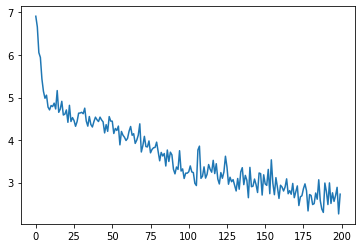

returned loss 2.7267239046809464


 Iteration: 201
returned loss 2.6087866588550455


 Iteration: 202
returned loss 2.422009169792903


 Iteration: 203
returned loss 2.6022381202363576


 Iteration: 204
returned loss 2.280313407023898


 Iteration: 205
returned loss 2.4977655255905704


 Iteration: 206
returned loss 2.3276596143638177


 Iteration: 207
returned loss 2.5061064905722934


 Iteration: 208
returned loss 2.630682924970404


 Iteration: 209
returned loss 2.6545802551710347


 Iteration: 210
returned loss 2.507651796942902


 Iteration: 211
returned loss 2.442120376847477


 Iteration: 212
returned loss 2.1574600781468827


 Iteration: 213
returned loss 2.141432453541601


 Iteration: 214
returned loss 3.148665568760286


 Iteration: 215
returned loss 2.687888761790835


 Iteration: 216
returned loss 2.3047356423973056


 Iteration: 217
returned loss 2.3540730168546973


 Iteration: 218
returned loss 2.384853895579949


 Iteration: 219
returned loss 2.2606746130731215


 Iter

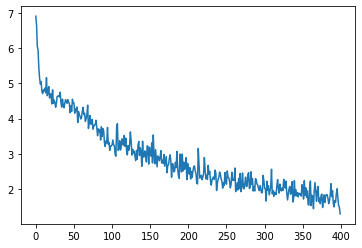

returned loss 1.2879831974739238


 Iteration: 401
returned loss 1.8538236337837715


 Iteration: 402
returned loss 1.8606334651625205


 Iteration: 403
returned loss 1.7083323621355788


 Iteration: 404
returned loss 1.4575623455260804


 Iteration: 405
returned loss 1.8031082431708816


 Iteration: 406
returned loss 1.6786451978040133


 Iteration: 407
returned loss 1.6655128685287737


 Iteration: 408
returned loss 1.6701987657476873


 Iteration: 409
returned loss 1.5521441353864014


 Iteration: 410
returned loss 1.8527664498601906


 Iteration: 411
returned loss 1.73594898329862


 Iteration: 412
returned loss 1.7720104284556533


 Iteration: 413
returned loss 2.057677125584334


 Iteration: 414
returned loss 1.3203329831739603


 Iteration: 415
returned loss 1.6066375299325593


 Iteration: 416
returned loss 1.7678411693152571


 Iteration: 417
returned loss 1.6147534688912133


 Iteration: 418
returned loss 1.723654481666796


 Iteration: 419
returned loss 1.567379586638633


 

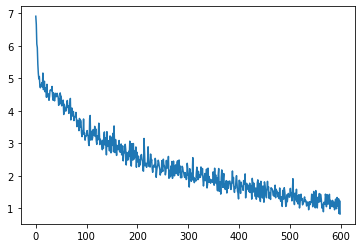

returned loss 0.825897647022158


 Iteration: 601
returned loss 0.9512055210259224


 Iteration: 602
returned loss 0.9993776464701611


 Iteration: 603
returned loss 0.8582668389026267


 Iteration: 604
returned loss 1.0087399393665843


 Iteration: 605
returned loss 0.9392879837578721


 Iteration: 606
returned loss 1.0900352018257684


 Iteration: 607
returned loss 1.0668354527045925


 Iteration: 608
returned loss 0.947190540682882


 Iteration: 609
returned loss 0.9317415243670782


 Iteration: 610
returned loss 1.0888476296341505


 Iteration: 611
returned loss 0.9164580459419135


 Iteration: 612
returned loss 1.1806755184776734


 Iteration: 613
returned loss 0.938098736710303


 Iteration: 614
returned loss 1.1592693565204009


 Iteration: 615
returned loss 1.030695119951157


 Iteration: 616
returned loss 1.1626526375603339


 Iteration: 617
returned loss 0.9091073771423034


 Iteration: 618
returned loss 1.0359873407501665


 Iteration: 619
returned loss 0.8728603448897064




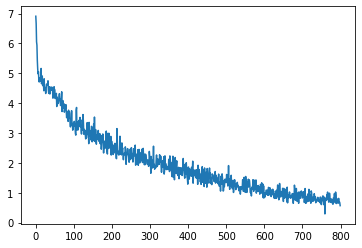

returned loss 0.5679835642465798


 Iteration: 801
returned loss 0.9175632495002325


 Iteration: 802
returned loss 0.7429927515354708


 Iteration: 803
returned loss 0.5582914665919537


 Iteration: 804
returned loss 0.719580969515738


 Iteration: 805
returned loss 0.7122967904174907


 Iteration: 806
returned loss 0.8800094344973066


 Iteration: 807
returned loss 0.8470069641189838


 Iteration: 808
returned loss 0.8769774278455104


 Iteration: 809
returned loss 0.6868319009397114


 Iteration: 810
returned loss 0.59754818801709


 Iteration: 811
returned loss 0.7161968294615932


 Iteration: 812
returned loss 0.6636644591562799


 Iteration: 813
returned loss 0.7268505019594484


 Iteration: 814
returned loss 0.6907160848823762


 Iteration: 815
returned loss 0.7576746602715765


 Iteration: 816
returned loss 0.6655592741514115


 Iteration: 817
returned loss 0.7533147618484993


 Iteration: 818
returned loss 0.7141640242079601


 Iteration: 819
returned loss 0.6670234220696366



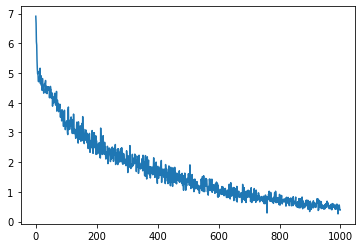

returned loss 0.39229986830611546


 Iteration: 1001
returned loss 0.5341820471315163


 Iteration: 1002
returned loss 0.48073919393187003


 Iteration: 1003
returned loss 0.4785203425077877


 Iteration: 1004
returned loss 0.41023545460683103


 Iteration: 1005
returned loss 0.40716755617347855


 Iteration: 1006
returned loss 0.4168278690347329


 Iteration: 1007
returned loss 0.5604271215001124


 Iteration: 1008
returned loss 0.4710453119835889


 Iteration: 1009
returned loss 0.534717767821324


 Iteration: 1010
returned loss 0.43115851084719625


 Iteration: 1011
returned loss 0.3904854192724743


 Iteration: 1012
returned loss 0.46456024694506864


 Iteration: 1013
returned loss 0.5352840997447348


 Iteration: 1014
returned loss 0.5161057147273939


 Iteration: 1015
returned loss 0.3817944559720802


 Iteration: 1016
returned loss 0.40158903682480107


 Iteration: 1017
returned loss 0.38091945416095807


 Iteration: 1018
returned loss 0.38145445634880204


 Iteration: 1019
retu

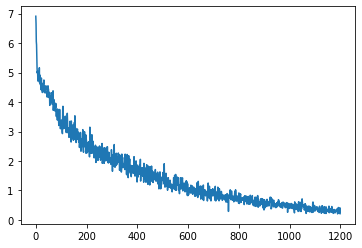

returned loss 0.21425425950192137


 Iteration: 1201
returned loss 0.2337457251453184


 Iteration: 1202
returned loss 0.21000747001657108


 Iteration: 1203
returned loss 0.2910627837387773


 Iteration: 1204
returned loss 0.5054155117153968


 Iteration: 1205
returned loss 0.38629669382484566


 Iteration: 1206
returned loss 0.30414434786004135


 Iteration: 1207
returned loss 0.39181977160702053


 Iteration: 1208
returned loss 0.37618137308174676


 Iteration: 1209
returned loss 0.21298277509564395


 Iteration: 1210
returned loss 0.2335250381084383


 Iteration: 1211
returned loss 0.2340288309921191


 Iteration: 1212
returned loss 0.23461024879368894


 Iteration: 1213
returned loss 0.36408097875905493


 Iteration: 1214
returned loss 0.3091934084430876


 Iteration: 1215
returned loss 0.25228505667270706


 Iteration: 1216
returned loss 0.21191833498319876


 Iteration: 1217
returned loss 0.278254477675524


 Iteration: 1218
returned loss 0.31803064609320614


 Iteration: 1219
r

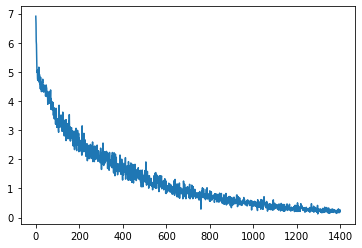

returned loss 0.19849697118535792


 Iteration: 1401
returned loss 0.23265827705054057


 Iteration: 1402
returned loss 0.22465791250532313


 Iteration: 1403
returned loss 0.24370142908038012


 Iteration: 1404
returned loss 0.1959295334458325


 Iteration: 1405
returned loss 0.16875988165402092


 Iteration: 1406
returned loss 0.20478818894662773


 Iteration: 1407
returned loss 0.342052206789269


 Iteration: 1408
returned loss 0.220082232520819


 Iteration: 1409
returned loss 0.20947598407637597


 Iteration: 1410
returned loss 0.16040191397818845


 Iteration: 1411
returned loss 0.19810023267906196


 Iteration: 1412
returned loss 0.18083521878738626


 Iteration: 1413
returned loss 0.2036124993449903


 Iteration: 1414
returned loss 0.17226094839678285


 Iteration: 1415
returned loss 0.16866101310773773


 Iteration: 1416
returned loss 0.284885267210755


 Iteration: 1417
returned loss 0.24312103709294566


 Iteration: 1418
returned loss 0.2830035177484479


 Iteration: 1419
re

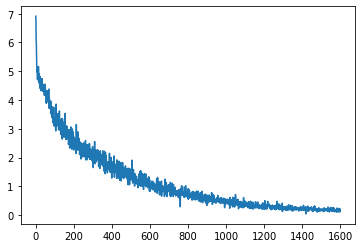

returned loss 0.2071319966020201


 Iteration: 1601
returned loss 0.1898943257164287


 Iteration: 1602
returned loss 0.11964741901957916


 Iteration: 1603
returned loss 0.20111953700827204


 Iteration: 1604
returned loss 0.15645872575145617


 Iteration: 1605
returned loss 0.19602330606404386


 Iteration: 1606
returned loss 0.17991616274943512


 Iteration: 1607
returned loss 0.22676412728941928


 Iteration: 1608
returned loss 0.1669399920757704


 Iteration: 1609
returned loss 0.16330233705306804


 Iteration: 1610
returned loss 0.1871104248070988


 Iteration: 1611
returned loss 0.12728613315962517


 Iteration: 1612
returned loss 0.20643227824431679


 Iteration: 1613
returned loss 0.20888462637747832


 Iteration: 1614
returned loss 0.22244221251749974


 Iteration: 1615
returned loss 0.1576537777734385


 Iteration: 1616
returned loss 0.15485841732587222


 Iteration: 1617
returned loss 0.12562125108681998


 Iteration: 1618
returned loss 0.18755873562991104


 Iteration: 161

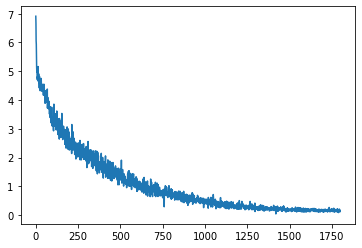

returned loss 0.1635744003428957


 Iteration: 1801
returned loss 0.20390658302487202


 Iteration: 1802
returned loss 0.11708587154030933


 Iteration: 1803
returned loss 0.12250072732329315


 Iteration: 1804
returned loss 0.09798843826241742


 Iteration: 1805
returned loss 0.10737558010397964


 Iteration: 1806
returned loss 0.21197223493624917


 Iteration: 1807
returned loss 0.168351822387378


 Iteration: 1808
returned loss 0.16562270216227046


 Iteration: 1809
returned loss 0.15902803570028518


 Iteration: 1810
returned loss 0.18113456308434783


 Iteration: 1811
returned loss 0.18049984348759793


 Iteration: 1812
returned loss 0.13426400932772295


 Iteration: 1813
returned loss 0.1474893245190995


 Iteration: 1814
returned loss 0.1766491240131505


 Iteration: 1815
returned loss 0.1206271913189107


 Iteration: 1816
returned loss 0.15824876543597693


 Iteration: 1817
returned loss 0.1385346622267255


 Iteration: 1818
returned loss 0.12376924254153003


 Iteration: 1819


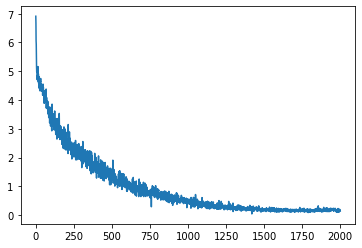

returned loss 0.14315577393561674


 Iteration: 2001
returned loss 0.13004707188378697


 Iteration: 2002
returned loss 0.16083644102669506


 Iteration: 2003
returned loss 0.16162334645604606


 Iteration: 2004
returned loss 0.1593084060522457


 Iteration: 2005
returned loss 0.21703287843238436


 Iteration: 2006
returned loss 0.14155931258648946


 Iteration: 2007
returned loss 0.16891925118893986


 Iteration: 2008
returned loss 0.14808429693339717


 Iteration: 2009
returned loss 0.1119880276702229


 Iteration: 2010
returned loss 0.1964077409644717


 Iteration: 2011
returned loss 0.16393735887249933


 Iteration: 2012
returned loss 0.18226771637082875


 Iteration: 2013
returned loss 0.21420163911987525


 Iteration: 2014
returned loss 0.18950571087556736


 Iteration: 2015
returned loss 0.10711974522817906


 Iteration: 2016
returned loss 0.17879847066648258


 Iteration: 2017
returned loss 0.20405437279744515


 Iteration: 2018
returned loss 0.18827846261011505


 Iteration: 2

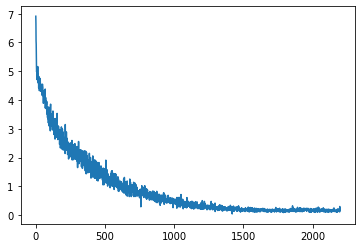

returned loss 0.18157407549840288


 Iteration: 2201
returned loss 0.24099773255267604


 Iteration: 2202
returned loss 0.15905014317125057


 Iteration: 2203
returned loss 0.1421203909428242


 Iteration: 2204
returned loss 0.22161208727553458


 Iteration: 2205
returned loss 0.15644735137166793


 Iteration: 2206
returned loss 0.20669047063752372


 Iteration: 2207
returned loss 0.18106385336777625


 Iteration: 2208
returned loss 0.16132694482955987


 Iteration: 2209
returned loss 0.19863852747519456


 Iteration: 2210
returned loss 0.1349625788477122


 Iteration: 2211
returned loss 0.22478773336293079


 Iteration: 2212
returned loss 0.19249119291026268


 Iteration: 2213
returned loss 0.2224949705806356


 Iteration: 2214
returned loss 0.23571494537881454


 Iteration: 2215
returned loss 0.1918810462407968


 Iteration: 2216
returned loss 0.22081683675931366


 Iteration: 2217
returned loss 0.13515342042711317


 Iteration: 2218
returned loss 0.21699869904026514


 Iteration: 22

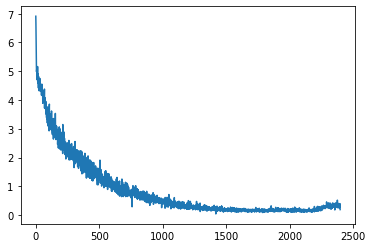

returned loss 0.19343452493394309


 Iteration: 2401
returned loss 0.3147827424831396


 Iteration: 2402
returned loss 0.33745775697574304


 Iteration: 2403
returned loss 0.4460381756764112


 Iteration: 2404
returned loss 0.2921852668767831


 Iteration: 2405
returned loss 0.24789107063985835


 Iteration: 2406
returned loss 0.32617711366398916


 Iteration: 2407
returned loss 0.32284380056361023


 Iteration: 2408
returned loss 0.40617529496787236


 Iteration: 2409
returned loss 0.43416633504877317


 Iteration: 2410
returned loss 0.3335719463768259


 Iteration: 2411
returned loss 0.3070614564384836


 Iteration: 2412
returned loss 0.3941350185607114


 Iteration: 2413
returned loss 0.23934199781846235


 Iteration: 2414
returned loss 0.24546702899065045


 Iteration: 2415
returned loss 0.24061997312059075


 Iteration: 2416
returned loss 0.43160773103168076


 Iteration: 2417
returned loss 0.17869566960094047


 Iteration: 2418
returned loss 0.36547996750946443


 Iteration: 2419

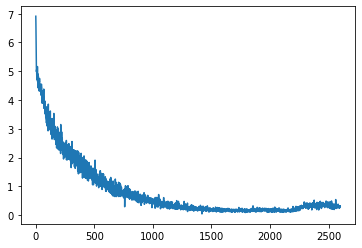

returned loss 0.31542399558930373


 Iteration: 2601
returned loss 0.22224657484526433


 Iteration: 2602
returned loss 0.2659169509573414


 Iteration: 2603
returned loss 0.28256739255244734


 Iteration: 2604
returned loss 0.33660892627803707


 Iteration: 2605
returned loss 0.2332110811402926


 Iteration: 2606
returned loss 0.3794546365251027


 Iteration: 2607
returned loss 0.38041645996702234


 Iteration: 2608
returned loss 0.31025022999591906


 Iteration: 2609
returned loss 0.3278449232018263


 Iteration: 2610
returned loss 0.373640585950858


 Iteration: 2611
returned loss 0.2374675464305223


 Iteration: 2612
returned loss 0.2250614560694511


 Iteration: 2613
returned loss 0.25474801014645737


 Iteration: 2614
returned loss 0.3192054643157422


 Iteration: 2615
returned loss 0.30063583057596976


 Iteration: 2616
returned loss 0.30903371173109373


 Iteration: 2617
returned loss 0.33853765885176507


 Iteration: 2618
returned loss 0.19129986050981518


 Iteration: 2619
re

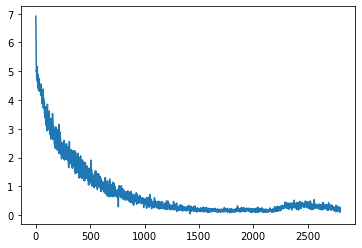

returned loss 0.11151610658727387




In [55]:
LEARN_RATE = 0.001
clip = 50.0
# num_iters = 400
DESIRED_LOSS = 0.1

small_batch_size = 30
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model,  embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
#pass models to device 
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.train()
decoder.train()

#optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARN_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARN_RATE)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()


# start training
print("START TRAINING")
print("\n")

returned_losses = []

iteration = 0
# for iteration in range(num_iters):
while iteration < 2800:
    iteration += 1
    
    print(" Iteration:", iteration)
    
    batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches
    
    #train one iter
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0
    

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
#     print("encoder output shape", encoder_outputs.shape)
#     print("last encoder hidden shape", encoder_hidden.shape)

    decoder_input = torch.LongTensor([[SOS_token for _ in range (small_batch_size)]])
    decoder_input = decoder_input.to(device)
#     print("initial decoder input shape", decoder_input.shape)
#     print(decoder_input)

    decoder_hidden =  encoder_hidden[:decoder.n_layers]
#     print("initial decoder hidden state shape", decoder_hidden.shape)

    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

        #teacher forcing
        decoder_input = target_variable[t].view(1,-1)

        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)

        n_totals += nTotal
        
    #simulated student eval
    
    if iteration > 300 and iteration % 20 == 0:
        encoder.eval()
        decoder.eval()

        searcher = GreedySearchDecoder(encoder, decoder)
        tutor_score = simulate_with_student(encoder, decoder, searcher, voc)
        encoder.train()
        decoder.train()

        loss = loss * tutor_score / 5
        returned_loss = sum(print_losses) / n_totals * tutor_score / 5
    else:
        returned_loss = sum(print_losses) / n_totals
        
    loss.backward(retain_graph=True)
    
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    
    returned_losses.append(returned_loss)
    
    if iteration % 200 == 0:   
        plt.plot(returned_losses)
        plt.show()
    
    print("returned loss", returned_loss)
#     print(returned_losses)
    print("\n")
    



EVALUATION on validation set

In [50]:
TEST_SIZE = 30

encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)

evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE)

past convo: Tutor: "Is In Front Of The" is "e di fronte al". Please try to fill in the blank in Italian.  Student: il cane e di fronte al.  Tutor: Well,  "bunny" is  "coniglio" Student: What thes word for yellow? I almost have it.  Tutor: Can you try filling in the blank to the best of your ability? Student: il cane e di cronte al coniglio.  Tutor: Can you give me your best guess? Student: il cane e di cronte al coniglio. Is my best guess of how the sentence is suppose to look.  Tutor: Hmm...  "is in front of the" is  "e di fronte al" Student: il cane e di fronte al coniglio. 


Bot: the word for yellow or can you try to fill in the blank ? . cane try again . it should be al


Correct:  now add yellow, "giallo"


past convo: Tutor: "Plant" is "pianta". Please try to fill in the blank in Italian.  Student: Hello? Tutor: alla ("to the") is used when the following word (pianta) is feminine and a singular object.  It is a contraction of a ("to") and la ("the"). When the following word begi